<a href="https://colab.research.google.com/github/rammne/fastai-cn101/blob/main/FASTAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook

     |████████████████████████████████| 720 kB 5.3 MB/s 
     |████████████████████████████████| 48 kB 4.8 MB/s 
     |████████████████████████████████| 189 kB 47.1 MB/s 
     |████████████████████████████████| 1.2 MB 40.4 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 51 kB 328 kB/s 
     |████████████████████████████████| 561 kB 41.2 MB/s 
     |████████████████████████████████| 130 kB 47.4 MB/s 


In [2]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from pathlib import Path

Mounted at /content/gdrive


In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'c769cff323d34e6fb2364b32cd80d08c')

In [4]:
objects = 'car','dog','bicycle', 'cat', 'ship'
path = Path('vehicles')

if not path.exists():
    path.mkdir()
    for o in objects:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} pictures')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [5]:
fns = get_image_files(path)

In [6]:
failed = verify_images(fns)
failed.map(Path.unlink);

In [7]:
objects = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=1),
    get_y=parent_label,
    item_tfms=Resize(128))
    
dls = objects.dataloaders(path)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


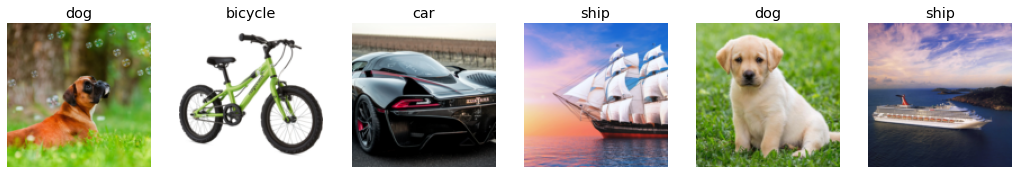

In [8]:
dls.valid.show_batch(max_n=6, nrows=1)

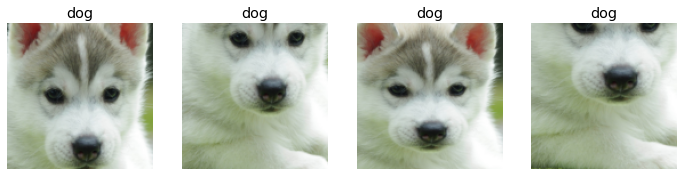

In [9]:
objects = objects.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = objects.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


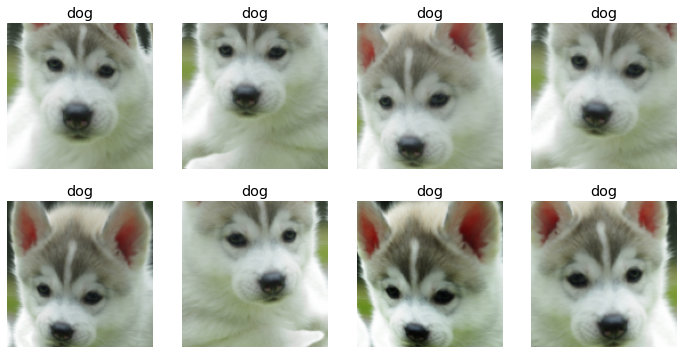

In [10]:
objects = objects.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = objects.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [11]:
objects = objects.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = objects.dataloaders(path)

In [12]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.689193,0.036582,0.014085,00:44


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.119712,0.011128,0.000000,00:44
1,0.077518,0.003386,0.000000,00:44
2,0.056305,0.001808,0.000000,00:44
3,0.045351,0.001425,0.000000,00:43


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


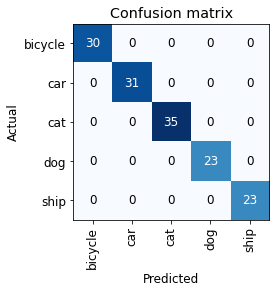

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

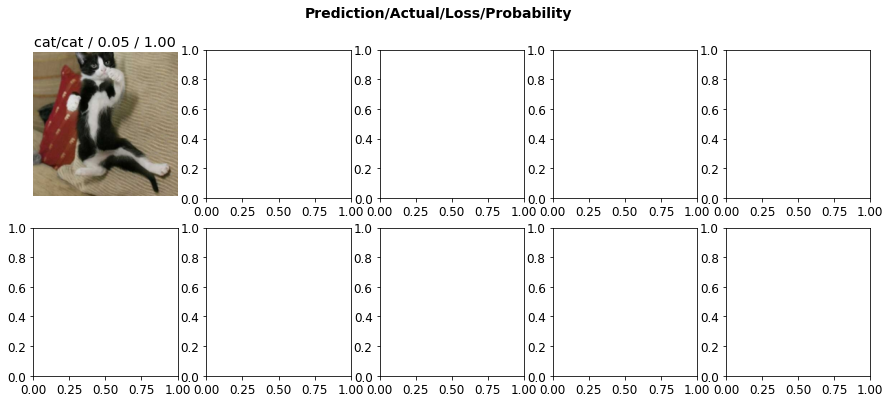

In [14]:
interp.plot_top_losses(10, nrows=2)

In [15]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [16]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [17]:
learn.export('vehicles.pkl')

In [18]:
path = Path()
learn_inf = load_learner(path/'vehicles.pkl')

In [19]:
learn_inf.dls.vocab

['bicycle', 'car', 'cat', 'dog', 'ship']

In [20]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [21]:
img = PILImage.create(btn_upload.data[-1])

In [22]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [23]:
pred,pred_idx,probs = learn_inf.predict(img)

In [24]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: dog; Probability: 0.9935')

In [25]:
btn_run = widgets.Button(description='Classify')

In [26]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [27]:
VBox([widgets.Label('upload an object'), 
      btn_upload, btn_run, out_pl, lbl_pred])